In [1]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import pandas as pd

In [3]:
from keras.utils import get_file
import os

data_url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/3364/31151/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1680078705&Signature=W4uo0K38pAShcXVllaMJcvCTjL%2BMGznXp3Mvd1SsWk9NfJbxv8%2F49T4%2BgmOkLys3dpsQnCOTJC6FjNrFkqleflwAe3560IRjLqeF08ecWvA4ueKsXSK9INF8As%2FUefs8HQgSwJK2X43Aeidr2UXn8meE%2B%2FoTwV1rsu%2BstXdYZjvSxAMhIqwWaENLXy63wYWYJ6%2B4EvKQstBWbNbx56EvNXYeCXj9WyzOAjrcRSLVuhDMY1KkrOp4v%2BYhboPOkzVNGxTX7Sb%2Bc5tHgxc1ogrkzY%2BWBXu7JqYOga%2FtYtjmmVlcvHyOnOZun4My%2BwJgrxcubVtmMEBBzT0suvYCDIiW5w%3D%3D&response-content-disposition=attachment%3B+filename%3Dchallenges-in-representation-learning-facial-expression-recognition-challenge.zip'

zip_file = get_file(fname = 'challenges-in-representation-learning-facial-expression-recognition-challenge.zip', origin = data_url, extract = True)

base_dir, extension = os.path.splitext(zip_file)

train = pd.read_csv('/root/.keras/datasets/train.csv')

train['pixels'] = [np.fromstring(x, dtype = int, sep = ' ').reshape(-1, 48, 48, 1) for x in train['pixels']]
pixels = np.concatenate(train['pixels'])
labels = train.emotion.values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.2, random_state = 101)

X_train_new = np.repeat(X_train, repeats = 3, axis = 3)
X_test_new = np.repeat(X_test, repeats = 3, axis = 3)

In [4]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

X_train_new.shape, X_test_new.shape, y_train.shape, y_test.shape

((22967, 48, 48, 3), (5742, 48, 48, 3), (22967, 7), (5742, 7))

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72 
patch_size = 6  
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 7
mlp_head_units = [2048, 1024]

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        #layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(X_train_new)

In [7]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [8]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 36


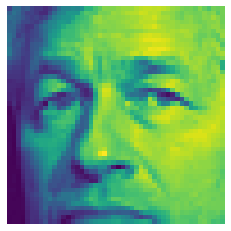

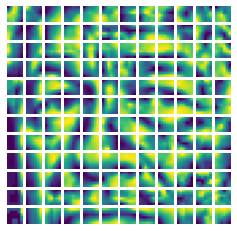

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train_new.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [10]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [11]:
input_shape = (48, 48, 3)
num_classes = 7

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
 
    logits = layers.Dense(num_classes)(features)
    
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
import tensorflow_addons as tfa

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train_new,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test_new, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100


81/81 [==============================] - 348s 4s/step - loss: 2.2220 - accuracy: 0.2271 - top-5-accuracy: 0.8609 - val_loss: 1.7718 - val_accuracy: 0.2708 - val_top-5-accuracy: 0.8964
Epoch 2/100
81/81 [==============================] - 331s 4s/step - loss: 1.7799 - accuracy: 0.2786 - top-5-accuracy: 0.8988 - val_loss: 1.6886 - val_accuracy: 0.3343 - val_top-5-accuracy: 0.9177
Epoch 3/100
81/81 [==============================] - 334s 4s/step - loss: 1.7235 - accuracy: 0.3086 - top-5-accuracy: 0.9119 - val_loss: 1.6604 - val_accuracy: 0.3500 - val_top-5-accuracy: 0.9251
Epoch 4/100
81/81 [==============================] - 327s 4s/step - loss: 1.6993 - accuracy: 0.3289 - top-5-accuracy: 0.9172 - val_loss: 1.6412 - val_accuracy: 0.3683 - val_top-5-accuracy: 0.9325
Epoch 5/100
81/81 [==============================] - 334s 4s/step - loss: 1.6614 - accuracy: 0.3436 - top-5-accuracy: 0.9226 - val_loss: 1.5903 - val_accuracy: 0.3931 - val_top-5-accuracy: 0.9386
Epoch 6/100
81/81 [=============

In [ ]:
tf.keras.models.save_model(vit_classifier, 'vit_model.hdf5')

In [ ]:
score = vit_classifier.evaluate(X_test_new)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

from sklearn.metrics import confusion_matrix

y_pred = history.predict(X_train_new).argmax(axis = 1)
y_train = np.argmax(y_train, axis = 1)

confusion_matrix(y_train, y_pred)

In [ ]:
plt.figure(figsize=(6, 6))
plt.title('Model accuracy')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()